In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import os
import scipy
from scipy.stats import poisson
from astropy import units as u
import astropy.constants as const

In [2]:
# convenience units
u.m2 = pow(u.m, 2)
u.cm2 = pow(u.cm, 2)
u.cm3 = pow(u.cm, 3)
# add missing constants
const.pi = np.pi
const.k = 8.6173324e-5 * u.eV / u.K  # boltzmann constant
const.q = const.e.si
const.kt = (const.k * 300 * u.K).to('J')
const.ktq = const.kt.to('eV')
const.Vt = (const.ktq / const.q).to('V')

In [3]:
eps_r = 9.7
alpha = 200e3 / u.cm
Eg = 3.4 * u.eV
chi = 3.2 * u.eV
Ephonon = 0.092 * u.eV

# Surface Band Bending

In [4]:
def depletion_width(Nd, delV):
    return np.sqrt((2. * eps_r * const.eps0 * delV) / (const.q * const.q * Nd)).to('nm')

In [5]:
def band_bending(z, Nd, delV):
    zdep = depletion_width(Nd, delV)
    if(z > zdep):
        return 0. * u.eV
    prefactor = -const.q * const.q * Nd / (2. * eps_r * const.eps0)
    return (prefactor * (z - zdep) ** 2).to('eV')

In [6]:
def num_scatt(z, Nd, delV, delE, Esc, Chi):
    return -((band_bending(z, Nd, delV) - delV - delE + Chi) / Esc).value

In [7]:
def prob_reach_surface(z, Nd, delV, delE, Esc, Chi, scl):
    k = int(np.floor(num_scatt(z, Nd, delV, delE, Esc, Chi)))
    running_sum = 0.
    lp = (z / scl).value
    for i in range(k+1):
        running_sum += np.power(lp, i) / math.factorial(i)
    return running_sum * np.exp(-lp)

In [8]:
def absorption(x):
    return np.exp(-alpha * x).value

In [9]:
def norm_contribution(z, Nd, delV, delE, Esc, Chi, scl):
    p = prob_reach_surface(z, Nd, delV, delE, Esc, Chi, scl)
    return p * absorption(z)

In [33]:
def sigmoid(x, a):
    return 1. / (1. + np.exp(-a * x))

In [84]:
class Simulation(object):

    def __init__(self, Nd, delV, Eph, mfp):
        self.Nd = u.Quantity(Nd).to('cm^-3')
        self.delV = u.Quantity(delV).to('eV')
        self.Eph = u.Quantity(Eph)
        self.delE = (self.Eph - Eg).to('eV')
        self.mfp = u.Quantity(mfp).to('nm')
        self.wdep = np.sqrt((2. * eps_r * const.eps0 * self.delV) / (const.q * const.q * self.Nd)).to('nm')
    
    def V(self, x):
        if x > self.wdep:
            return u.Quantity('0 eV')
        prefactor = -const.q * const.q * self.Nd / (2. * eps_r * const.eps0)
        return (prefactor * (x - self.wdep) ** 2).to('eV')

    def dV(self, x):
        if x > self.wdep:
            return u.Quantity('0 eV/nm')
        prefactor = -const.q * const.q * self.Nd / (2. * eps_r * const.eps0)
        return (2. * prefactor * (x - self.wdep)).to('eV/nm')

    def scatt_direction(self, x, a):
        k = self.kc(x)
        return (sigmoid(1. - (x / self.wdep), a)**k + 1.) / 2.

    def kc(self, x):
#         numerator = self.V(x) + self.delE - self.delV + chi
#         return np.floor(((self.V(x) + self.delE - self.delV + chi) / Ephonon).value)
        return np.floor(((self.V(x) + self.delE + self.delV - chi) / Ephonon).value)
    
    def k_pmf(self, x):
        mu = (x / self.mfp).value
        k = self.kc(x)
        return poisson.pmf(k, mu)
        
    def k_cdf(self, x):
        mu = (x / self.mfp).value
        k = self.kc(x)
        return poisson.cdf(k, mu)

In [85]:
s = Simulation(Nd='1e17 cm^-3', delV='3.6 eV', Eph='5 eV', mfp='12 nm')

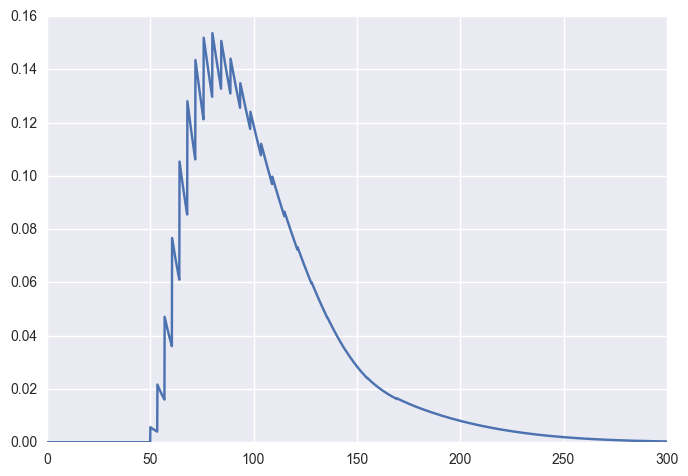

In [89]:
x = np.arange(0, 300, 0.1)
y = [absorption(_ * u.nm) * s.k_cdf(_ * u.nm) * s.scatt_direction(_ * u.nm, 10.) for _ in x]
plt.plot(x, y)

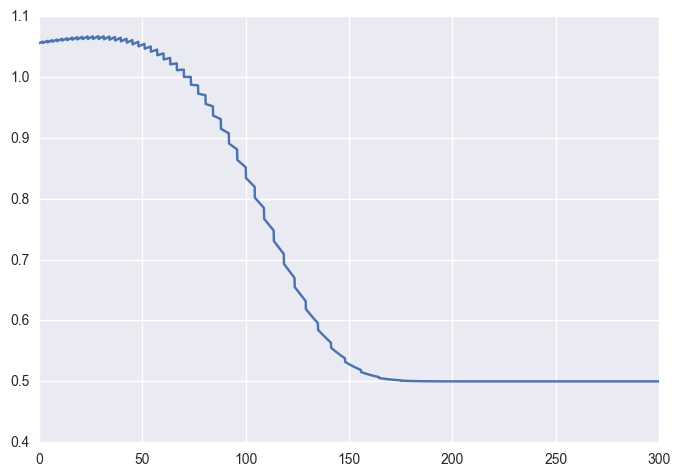

In [95]:
x = np.arange(0, 300, 0.1)
y = [s.scatt_direction((_ - 20.) * u.nm, 5.) for _ in x]
plt.plot(x, y)

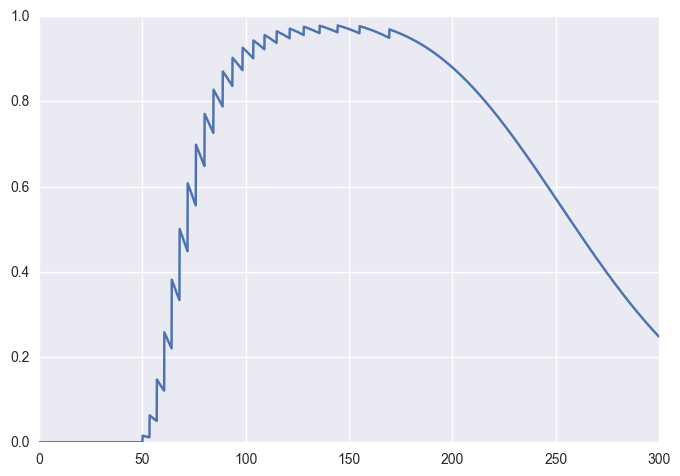

In [79]:
x = np.arange(0, 300, 0.1)
y = [s.k_cdf(_ * u.nm) for _ in x]
plt.plot(x, y)

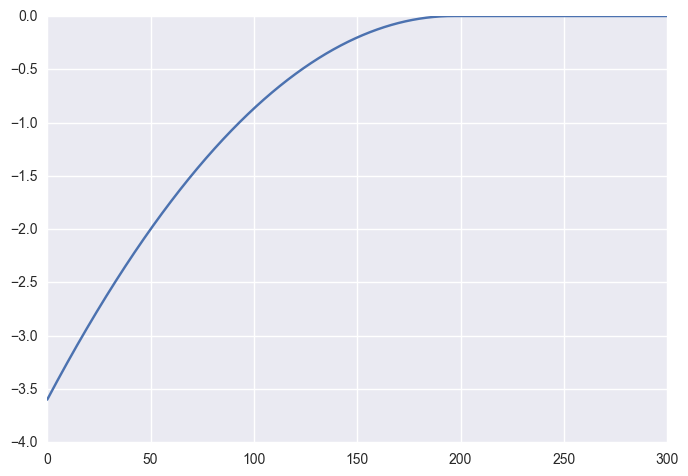

In [90]:
x = np.arange(0, 300, 0.1)
y = [s.V(_ * u.nm).value for _ in x]
plt.plot(x, y)

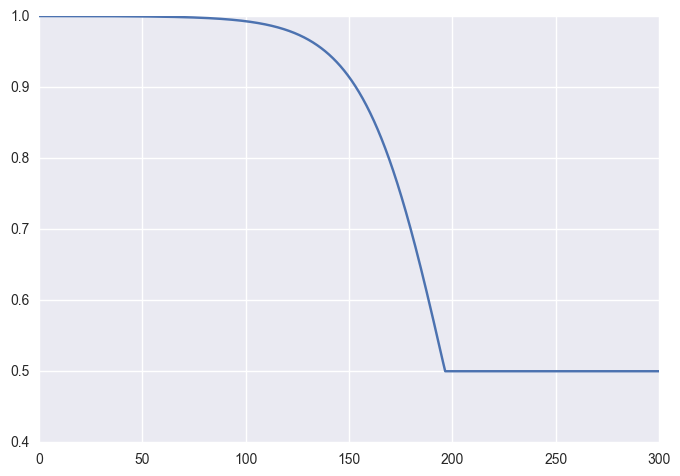

In [62]:
yy = [max(0.5, sigmoid(1. - ((_ * u.nm) / s.wdep), 10.)**1) for _ in x]
plt.plot(x, yy)

In [80]:
rs = 0.
for i in x:
    rs += norm_contribution(i * u.nm, 1e17 / u.cm3, 3. * u.eV, 1. * u.eV, 0.092 * u.eV, 3.2 * u.eV, 12 * u.nm, 100e3 / u.cm)

In [81]:
rs

737.51895156084049

In [7]:
for dop in [1e17, 3e17, 5e17, 7e17, 9e17, 1e18]:
    print('p={} w={:.3f}'.format(dop, depletion_width(dop / u.cm3, 1.2 * u.eV)))

p=1e+17 w=113.425 nm
p=3e+17 w=65.486 nm
p=5e+17 w=50.725 nm
p=7e+17 w=42.871 nm
p=9e+17 w=37.808 nm
p=1e+18 w=35.868 nm


In [8]:
bb = 1.2
df = pd.DataFrame({'x': x,
                   'V': np.array([band_bending(_ * u.nm, 1e17 / u.cm3, bb * u.eV).value + bb for _ in x])})

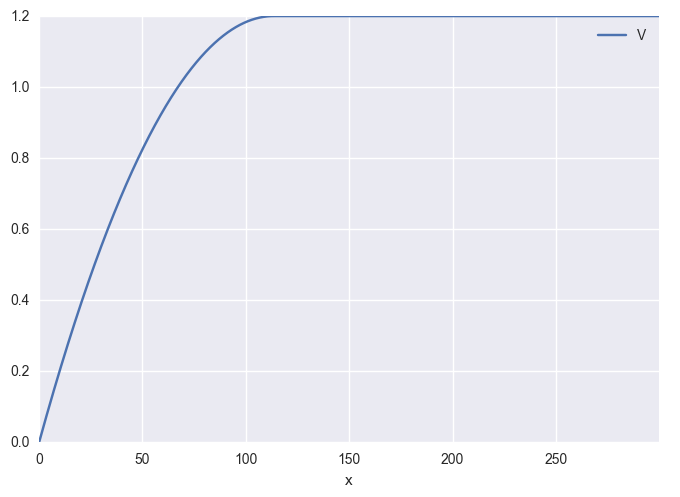

In [15]:
df.plot('x', 'V')

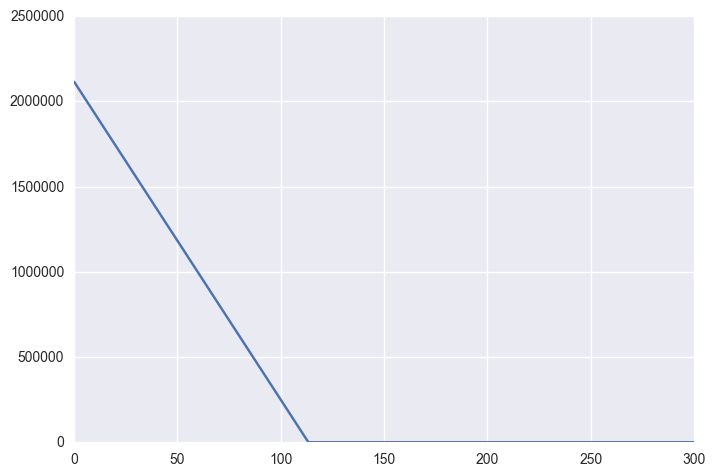

In [21]:
plt.plot(df.x, np.gradient(df.V) * 1e9)

# Photoexcited Carriers

In [22]:
def num_particles(x):
    return np.exp(-alpha * x)

In [23]:
df['n'] = np.array([num_particles(_ * u.nm) for _ in x])

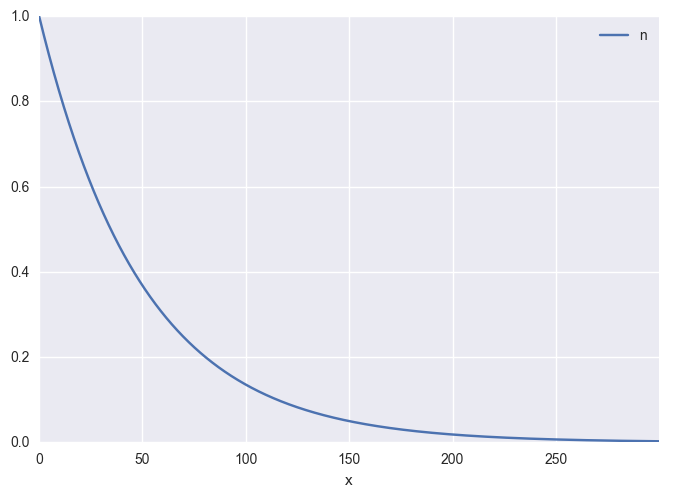

In [24]:
df.plot('x', 'n')

# Combination

In [25]:
Eph = 3.7 * u.eV
Evac = df.V.iloc[0] + chi.value
df['pe'] = df.V + (Eph - Eg).value

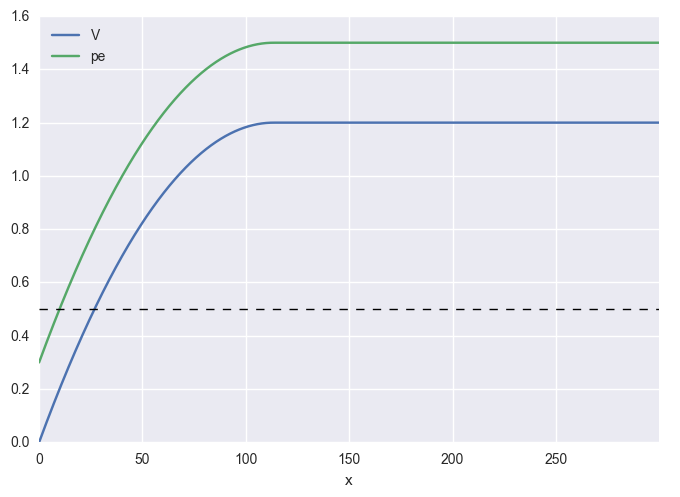

In [26]:
df.plot('x', ['V', 'pe'])
plt.axhline(Evac, c='k', ls='--', lw=1)

In [27]:
df[df.pe > Evac].x.min()

9.9000000000000004

In [32]:
df[df.pe > Evac].n.sum() / df.n.sum()

0.8199234880919728

In [28]:
df['esc'] = np.array(df.pe > Evac, dtype=np.float32)

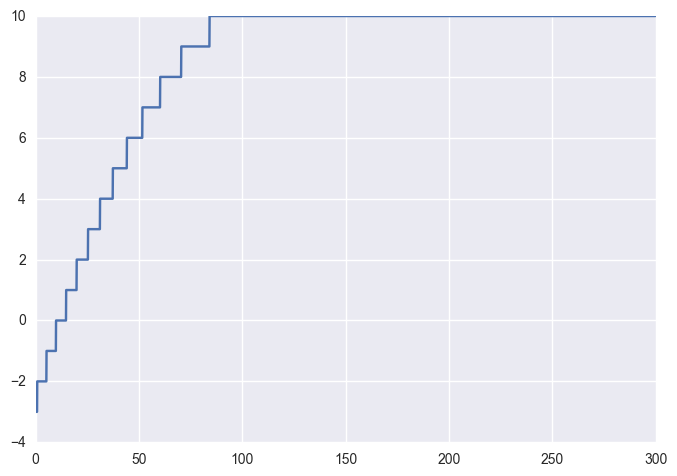

In [29]:
plt.plot(df.x, np.floor((df.pe - Evac) / Ephonon.value))

# Max QE Equation

In [45]:
def max_qe(Nd, delV, Eph, Chi):
    x = np.arange(0, 300, 0.1)
    df = pd.DataFrame({'x': x,
                       'V': np.array([band_bending(_ * u.nm, Nd / u.cm3, delV * u.eV).value + delV for _ in x]),
                       'n': np.array([num_particles(_ * u.nm) for _ in x])})
    Evac = df.V.iloc[0] + Chi
    df['pe'] = df.V + (Eph - Eg.value)
    return df[df.pe > Evac].n.sum() / df.n.sum()

In [59]:
def max_qe_quick(df, Eph, Chi):
    Evac = df.V.iloc[0] + Chi
    df['pe'] = df.V + (Eph - Eg.value)
    return df[df.pe > Evac].n.sum() / df.n.sum()

3.40: 0.380
3.60: 0.439
3.80: 0.486
4.00: 0.529
4.20: 0.569
4.40: 0.607
4.60: 0.644
4.80: 0.680
5.00: 0.717
5.20: 0.752
5.40: 0.788
5.60: 0.823


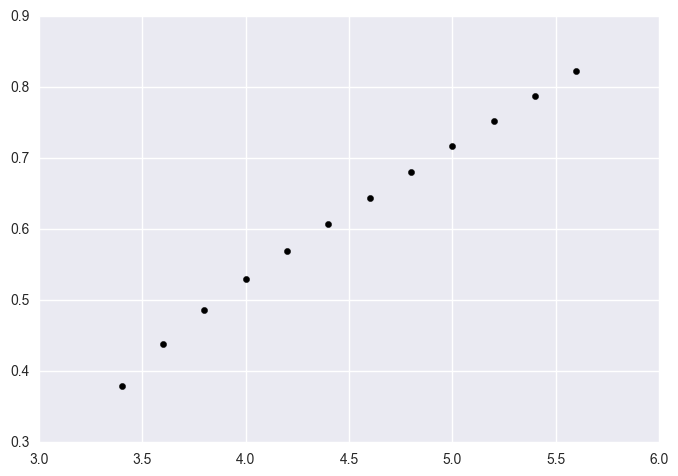

In [58]:
xx = np.arange(3.4, 5.7, 0.2)
yy = []
for Eph in xx:
    m = max_qe(Nd=1e18, delV=3.3, Eph=Eph, Chi=3.18)
    yy.append(m)
    print('{:.2f}: {:.3f}'.format(Eph, m))
plt.scatter(xx, yy, c='k')

In [69]:
def calc_max_qe(Nd, delV, Eph, Chi):
    yy = []
    x = np.arange(0, 300, 0.1)
    df = pd.DataFrame({'x': x,
                       'V': np.array([band_bending(_ * u.nm, Nd / u.cm3, delV * u.eV).value + delV for _ in x]),
                       'n': np.array([num_particles(_ * u.nm) for _ in x])})
    yy = np.array([max_qe_quick(df, Eph=E, Chi=Chi) for E in Eph])
    return yy

def plot_max_qe(Nd, delV, Eph, Chi):
    yy = calc_max_qe(Nd, delV, Eph, Chi)
    plt.scatter(Eph, yy, c='k')

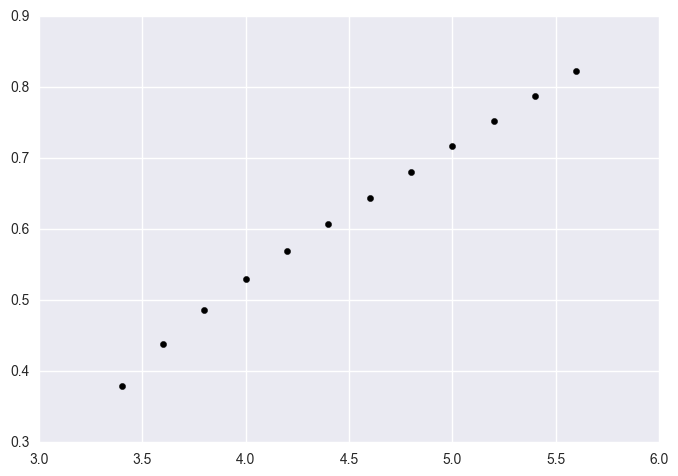

In [70]:
plot_max_qe(Nd=1e18, delV=3.3, Eph=np.arange(3.4, 5.7, 0.2), Chi=3.18)

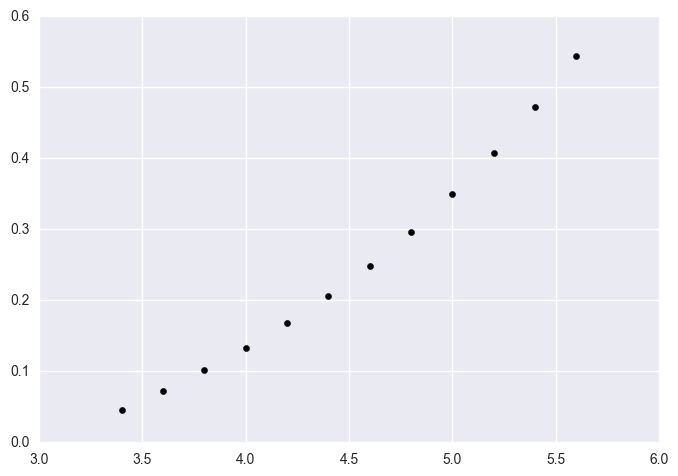

In [66]:
plot_max_qe(Nd=1e17, delV=3.3, Eph=np.arange(3.4, 5.7, 0.2), Chi=3.18)

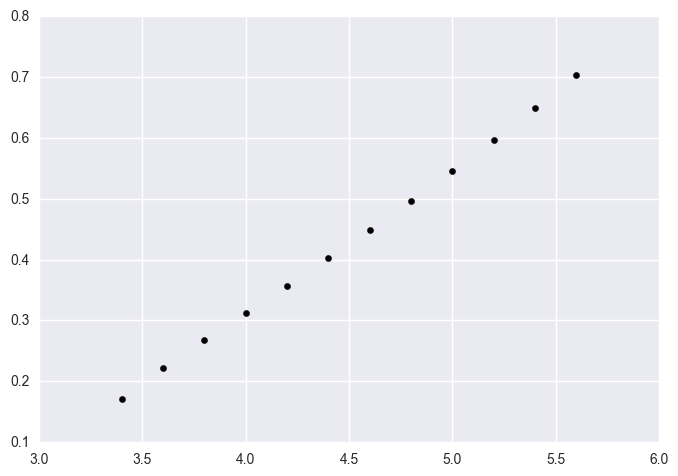

In [67]:
plot_max_qe(Nd=3e17, delV=3.3, Eph=np.arange(3.4, 5.7, 0.2), Chi=3.18)

In [71]:
def aggregate_max_qe(Nd, delV, Eph, Chi):
    yy = [calc_max_qe(n, delV, Eph, Chi) for n in Nd]
    return yy

In [75]:
yy = aggregate_max_qe(Nd=[1e17, 3e17, 5e17, 7e17, 1e18], delV=3.3, Eph=np.arange(3.4, 5.7, 0.2), Chi=3.18)

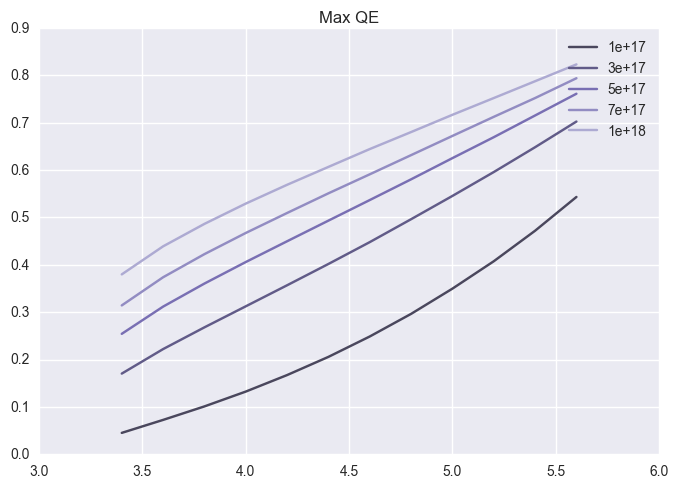

In [90]:
fig, ax = plt.subplots()
x = np.arange(3.4, 5.7, 0.2)
for (n, y), Nd in zip(enumerate(yy), [1e17, 3e17, 5e17, 7e17, 1e18]):
    ax.plot(x, y, c=sns.color_palette('Purples_d', len(yy))[n], label=Nd)
ax.legend()
ax.set_title('Max QE')